# Smart resume screener 

This notebook looks into using different data science libraries in an attempt to build an AI that takes a resume and a job description, and tells how well the resume fits the job. 

I am going to take this approach:
1. Define the problem
2. Data collection and preparation
3. Feature Extraction (Encoding Text)
4. Similarity + Scoring
5. Visualization & Insights


## 1. Define the problem:
We need to know the Top 5 job descriptions matches our resume

## 2. Data:
- The job description data come from Job Dataset in Kaggle at the description below:
<br>https://www.kaggle.com/datasets/kshitizregmi/jobs-and-job-description</br>
- While the Resumes data come from Resume Dataset in Kaggle at the description below:
<br>https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset/data</br>


# 3. Feature Extraction (Encoding Text):
- Convert each resume and job description to a vector <b>(using BERT)</b>
- Store vectors in memory or file

# 4. Similarity + Scoring
- Use <b>cosine similarity</b> to compare vectors.
- Output is a match score between 0 and 1.

- Match:

    - 1 job → many resumes

# 5. Visualization & Insights
- Use matplotlib to:
    - show top 5 matching resumes

# 6. UI/APP:
- Use <b>Streamlit</b> to create a simple interface:
 - Upload a resume
 - Upload a job description
 - Show the match score and highlights. 

# Data features
- For the job description dataset:
    - Job Title: Job titles associated with each description.
    - Job Description: Comprehensive job descriptions outlining responsibilities and qualifications.

- For the resume dataset:
    - ID: Unique identifier and file name for the respective pdf.
    - Resume_str : Contains the resume text only in string format.
    - Resume_html : Contains the resume data in html format as present while web scrapping.
    - Category : Category of the job the resume was used to apply.


## import the essential libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data Collection and prepration:

## import datasets:

In [2]:
import os
df_resumes = pd.read_csv(os.path.join("Data","Resume.csv"))

In [3]:
df_resumes.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [4]:
df_job_description = pd.read_csv(os.path.join("Data","job_description","job_title_des.csv"))

In [5]:
df_job_description.head()

,Unnamed: 0,Job Title,Job Description
0,0,Flutter Developer,We are looking for hire experts flutter develo...
1,1,Django Developer,PYTHON/DJANGO (Developer/Lead) - Job Code(PDJ ...
2,2,Machine Learning,"Data Scientist (Contractor)\n\nBangalore, IN\n..."
3,3,iOS Developer,JOB DESCRIPTION:\n\nStrong framework outside o...
4,4,Full Stack Developer,job responsibility full stack engineer – react...


In [6]:
# check if there are nan values in our data:
np.sum(pd.isna(df_resumes),axis=0)

ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64

In [7]:
np.sum(pd.isna(df_job_description),axis=0)

Unnamed: 0         0
Job Title          0
Job Description    0
dtype: int64

In [8]:
# determine the columns we will deal with
resume_str = df_resumes["Resume_str"]
job_description_str = df_job_description["Job Description"]

## Data prepration

In [9]:
# Check the GPU device
import torch

print(torch.version.cuda)        
print(torch.cuda.is_available()) 
print(torch.__version__) 

12.1
True
2.5.1+cu121


### Turn our data into bert-base-uncased inputs:

In [10]:
model_name = "google-bert/bert-base-uncased"
from transformers import AutoModel,AutoTokenizer
model = AutoModel.from_pretrained(model_name)
model = model.to("cuda").to(torch.float16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [11]:
%%time
# Turn our resume dataset into inputs
from functions import inputs_gpu
inputs_resume_gpu = inputs_gpu(data=resume_str ,tokenizer= tokenizer)

CPU times: total: 10.2 s
Wall time: 10.1 s


In [12]:
%%time
# Turn our description into inputs
inputs_descriptions_gpu = inputs_gpu(data=job_description_str,tokenizer=tokenizer)

CPU times: total: 3.45 s
Wall time: 3.4 s


### Get the last_hidden_state of your inputs

In [13]:
# get the last_hidden_state and padded_attention for our resume data
from functions import bert_base_outputs 
last_hidden_states_resume,padded_attention_mask_resume = bert_base_outputs(inputs=inputs_resume_gpu,batch_size=8,tokenizer=tokenizer,model=model)

C:\Users\legion\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [14]:
# get the last_hidden_state and padded_attention for our descripation data
last_hidden_states_descriptions,padded_attention_mask_descriptions =bert_base_outputs(inputs=inputs_descriptions_gpu,batch_size=8,tokenizer=tokenizer,model=model)

In [15]:
from torch.nn.utils.rnn import pad_sequence
last_hidden_states_resume = pad_sequence(last_hidden_states_resume,batch_first=True)
padded_attention_mask_resume= pad_sequence(padded_attention_mask_resume,batch_first=True)
padded_attention_mask_resume = padded_attention_mask_resume.unsqueeze(-1) 

In [16]:
last_hidden_states_resume.size(),padded_attention_mask_resume.size()

(torch.Size([2484, 512, 768]), torch.Size([2484, 512, 1]))

In [17]:
last_hidden_states_descriptions = pad_sequence(last_hidden_states_descriptions,batch_first=True)
padded_attention_mask_descriptions=pad_sequence(padded_attention_mask_descriptions,batch_first=True)
padded_attention_mask_descriptions = padded_attention_mask_descriptions.unsqueeze(-1) 

In [18]:
# def get_mean_pooling(last_hidden_states,attention_mask):
  #'''
 # a function to get the mean_pooling from the last hidden states and attention maskes
  #'''
  # masked_embeddings = last_hidden_states * attention_mask
  # sum_embeddings = masked_embeddings.sum(1)   
  # token_counts = attention_mask.sum(1)         
  # mean_pooled = sum_embeddings / torch.clamp(token_counts, min=1e-9)

 #  return mean_pooled


In [19]:
from functions import get_mean_pooling
resume_mean_embeddings = get_mean_pooling(last_hidden_states_resume,padded_attention_mask_resume)
description_mean_embeddings = get_mean_pooling(last_hidden_states_descriptions,padded_attention_mask_descriptions)

In [20]:
resume_mean_embeddings.size(),description_mean_embeddings.size()

(torch.Size([2484, 768]), torch.Size([2277, 768]))

## Get the **cosine similarity** of resume and descripation datasets: 

In [21]:
import torch
import torch.nn.functional as F
from functions import get_cosine_similarity
cosine_matrix = get_cosine_similarity(resume_mean_embeddings,description_mean_embeddings)
cosine_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,2267,2268,2269,2270,2271,2272,2273,2274,2275,2276
0,0.765180,0.793378,0.885487,0.856665,0.762086,0.913375,0.816877,0.836832,0.873155,0.894079,...,0.782604,0.856424,0.814811,0.798256,0.910834,0.890195,0.762748,0.761685,0.909591,0.806916
1,0.739644,0.759867,0.855926,0.846295,0.776430,0.881188,0.833277,0.829615,0.863721,0.889082,...,0.815329,0.840262,0.787937,0.798920,0.904091,0.881253,0.790503,0.738743,0.886445,0.819027
2,0.782749,0.784776,0.875765,0.839010,0.737886,0.893214,0.794738,0.820541,0.846678,0.883411,...,0.755545,0.869941,0.787246,0.782113,0.893422,0.882013,0.725485,0.786503,0.900570,0.791749
3,0.750695,0.792658,0.874945,0.843374,0.773467,0.903467,0.822677,0.841726,0.875457,0.895244,...,0.811682,0.846514,0.806832,0.811231,0.912988,0.889204,0.798535,0.760410,0.895027,0.808546
4,0.750719,0.786272,0.880176,0.868678,0.761127,0.921179,0.805897,0.844267,0.882056,0.910554,...,0.778062,0.877120,0.793361,0.799536,0.915381,0.898576,0.756585,0.749580,0.920299,0.798677


In [22]:
print(len(resume_str),len(job_description_str))
print(len(cosine_matrix),len(cosine_matrix.columns))

2484 2277
2484 2277


### Using SBERT model:

In [23]:
from functions import sbert_model
sim_cos =sbert_model(resume_str,job_description_str)
sim_cos

C:\Users\legion\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,0,1,2,3,4,5,6,7,8,9,...,2267,2268,2269,2270,2271,2272,2273,2274,2275,2276
0,0.247523,0.329670,0.254185,0.200179,0.337383,0.379628,0.421787,0.270297,0.325213,0.341856,...,0.437355,0.300996,0.220465,0.452823,0.440081,0.368544,0.349926,0.338771,0.536664,0.327659
1,0.296511,0.268868,0.214294,0.289696,0.418134,0.333509,0.451069,0.269323,0.277063,0.408663,...,0.444506,0.271427,0.130853,0.535708,0.493432,0.361115,0.415438,0.254131,0.389912,0.399001
2,0.113360,0.194007,0.157107,0.126938,0.251667,0.327966,0.328824,0.154032,0.207693,0.250053,...,0.379855,0.103091,0.084443,0.412136,0.322944,0.278280,0.295871,0.205038,0.371558,0.320736
3,0.304293,0.254132,0.306239,0.249787,0.349476,0.371580,0.349342,0.240830,0.308491,0.372698,...,0.418915,0.281071,0.161889,0.403327,0.460070,0.335481,0.299195,0.172963,0.460289,0.309310
4,0.279999,0.299787,0.224620,0.242192,0.349321,0.374718,0.389188,0.247295,0.314545,0.329988,...,0.412094,0.158674,0.154592,0.444020,0.385475,0.366994,0.375442,0.244821,0.468088,0.302193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2479,0.133432,0.196205,0.176606,0.115892,0.209479,0.206392,0.264514,0.154461,0.265172,0.251339,...,0.335319,0.166205,0.096608,0.316020,0.314881,0.245983,0.287354,0.200631,0.332294,0.239751
2480,0.164158,0.220488,0.165919,0.285494,0.296050,0.263443,0.323062,0.215739,0.254393,0.309828,...,0.411795,0.262125,0.073685,0.400247,0.340030,0.302484,0.324031,0.187045,0.427000,0.335367
2481,0.300262,0.335849,0.318915,0.252597,0.371741,0.360399,0.429469,0.268666,0.441438,0.381440,...,0.414652,0.180457,0.182197,0.438277,0.458648,0.433021,0.394129,0.202822,0.443769,0.295024
2482,0.255740,0.362696,0.355747,0.281028,0.255633,0.351635,0.321591,0.236316,0.364340,0.363398,...,0.409664,0.270106,0.161039,0.441132,0.393843,0.369426,0.271419,0.192095,0.425771,0.318736


## Visualization the top 5 descriptions:

In [24]:
from functions import get_jobtitle_descriptions_indexes_and_percentages

In [25]:
from functions import top_n_descriptions

In [26]:
# for BERT model
from functions import top_n_descriptions
top_n_descriptions(similarity_matrix = cosine_matrix,df_resumes=df_resumes,df_job_description=df_job_description)

Welcome 33176873, your Category is HR
 The Top 5 job descriptions for your resume are:

1. Java Developer_1401                 --> with 93.68%
2. Java Developer_1937                 --> with 92.90%
3. Java Developer_1380                 --> with 92.88%
4. Java Developer_1430                 --> with 92.78%
5. Java Developer_1604                 --> with 92.41%


In [27]:
# for SBERT model
top_n_descriptions(similarity_matrix = sim_cos,df_resumes=df_resumes,df_job_description=df_job_description)


Welcome 33176873, your Category is HR
 The Top 5 job descriptions for your resume are:

1. Database Administrator_1305         --> with 58.51%
2. Database Administrator_1454         --> with 55.98%
3. Java Developer_1465                 --> with 54.57%
4. Database Administrator_2041         --> with 52.49%
5. Database Administrator_1493         --> with 52.07%


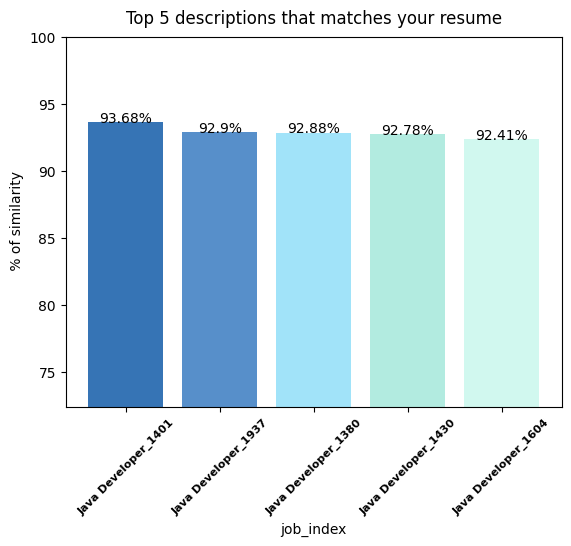

In [29]:
# For BERT model:
from functions import draw_top_n_descriptions
draw_top_n_descriptions(similarity_matrix= cosine_matrix,df_resumes=df_resumes,df_job_description=df_job_description)

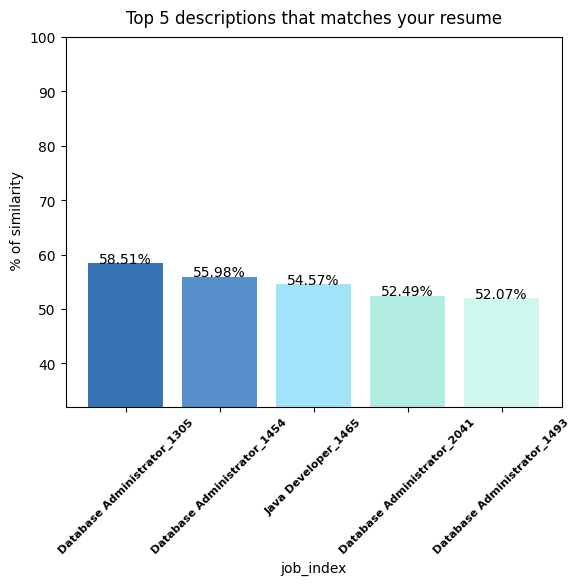

In [30]:
# For SBERT model:
draw_top_n_descriptions(similarity_matrix=sim_cos,df_resumes=df_resumes,df_job_description=df_job_description)

# Conclusion:
In this project, I built a tool to compare resumes and job descriptions using two transformer-based models:
1. BERT-base
2. SBERT

- **BERT-base** produced very high similarity scores, but it is not specialized for this task, so the results were less reliable. 

- **SBERT**, on the other hand, is specifically trained for semantic similarity and provided more meaningful and realistic results. The main value is not just the percentage, but the ranking of job matches, where SBERT performed much better.

- This shows how AI can be applied in resume screening to quickly identify the best-fitting job opportunities.

- The approach can be extended to other areas such as search engines, chatbots, and recommendation systems.